# Anomaly Detection Results
> We've trained the variational autoencoders, and in this post, we see how the models perform in anomaly detection. We check both the input and latent space for anomaly detection effectiveness.

In the [last post](https://www.tvhahn.com/posts/building-vae/) we built and trained a bunch of variational autoencoders to reconstruct milling machine signals. This is shown by steps 1 and 2 in the figure below. In this post, we'll be demonstrating the last step in the random search loop by checking a trained VAE model for its anomaly detection performance (step 3).

The anomaly detection is done using both the reconstruction error (input space anomaly detection) and measuring the difference in KL-divergence between samples (latent space anomaly detection). We'll see how this is done, and also dive into the results (plus pretty charts). Finally, I'll suggest some potential areas for further exploration. 

<div style="text-align: center; ">
<figure>
  <img src="images/vae_training_step3.jpg" alt="random search training process" style="background:none; border:none; box-shadow:none; text-align:center" width="800px"/>
  <div style="text-align: left; ">
  <figcaption style="color:grey; font-size:smaller">The random search training process has three steps. First, randomly select the hyperparameters. Second, train the VAE with these parameters. Third, check the anomaly detection performance of the trained VAE. In this post, we'll be looking at the third step. (Image from author)</figcaption>
  </div>
</figure>
</div>



## Setup Notebook

The notebook can be run with google colab. Alternatively, clone the repo and run on your local machine. You'll need python 3.6+ with the following packages in your local environment:

* Numpy
* SciPy
* Pandas
* Matplotlib
* Seaborn
* h5py
* scikit-learn

First, we will load all the neccessary packages.

In [1]:
import numpy as np
import scipy.io as sio # for reading matlab files
import pathlib
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import h5py

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from IPython.display import clear_output, display # clear the output if needed

%matplotlib inline

Set the appropriate working folders.

In [2]:
# move into the root directory of 'Manufacturing-Data-Science-with-Python'
cwd = Path.cwd() # current working directory
os.chdir('../')
root_dir = Path.cwd() # set the root directory as a Pathlib path

folder_raw_data = root_dir / 'Data Sets/milling_uc_berkeley/raw/' # raw data folder that holds the .zip .mat files for milling data
folder_processed_data = root_dir / 'Data Sets/milling_uc_berkeley/processed/' # processed data folder
working_folder = root_dir / 'Metal Machining' # working folder

folder_models = Path('models/') # folder for saved models

We now need to prepare the notebook by downloading the milling data file and other important files. This needs to be done if you are running in google colab. If the repository has been cloned from github, then there is no need.

In [4]:
# if the the raw data folder does not exist, then you are likely
# in a google colab environment. In that case, we will create the 
# raw data and processed data folders and download the appropriate
# files
if folder_raw_data.exists() == False:

    pathlib.Path(folder_raw_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_raw_data)
    !wget 'https://ti.arc.nasa.gov/m/project/prognostic-repository/mill.zip'
    
os.chdir(cwd) # change back to root directory

if folder_processed_data.exists() == False:

    pathlib.Path(folder_processed_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_processed_data)
    !wget 'https://raw.githubusercontent.com/tvhahn/Manufacturing-Data-Science-with-Python/master/Data%20Sets/milling_uc_berkeley/processed/labels_with_tool_class.csv'
    !wget 'https://raw.githubusercontent.com/tvhahn/Manufacturing-Data-Science-with-Python/master/Data%20Sets/milling_uc_berkeley/processed/data_processed.zip'
    
    
    os.chdir(cwd)
    
    # download important python files into the main directory
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data_prep.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/tcn.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/threshold.py'

if folder_models.exists() == False:

    pathlib.Path(folder_models / 'best_models').mkdir(parents=True, exist_ok=True)
    pathlib.Path(folder_models / 'saved_models').mkdir(parents=True, exist_ok=True)
    os.chdir(folder_models / 'best_models')
    !wget 'https://github.com/tvhahn/ml-tool-wear/raw/master/models/best_models/best_models.zip'
    
    os.chdir(cwd)    

# extract mill.mat from the zip file
with zipfile.ZipFile(folder_raw_data / 'mill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)
    
# extract best models from the zip file
with zipfile.ZipFile(folder_models / 'best_models' / 'best_models.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_models / 'best_models')
    
# extract the processed hdf5 files from the zip file
with zipfile.ZipFile(folder_processed_data / 'data_processed.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_processed_data)
    
# import those packages that we just downloaded
import data_prep
import threshold
from tcn import TCN

# Background

## Input Space Anomaly Detection
Our variational autoencoders have been trained on "healthy" tool wear data. As such, if we feed the trained VAEs data that is unhealthy, or just abnormal, we should generate a large reconstruction error (see my [previous post](https://www.tvhahn.com/posts/anomaly-detection-with-autoencoders/) for more details). A threshold can be set on this reconstruction error, whereby data producing a reconstruction error above the threshold is considered an anomaly. This is input space anomaly detection.

We'll measure the reconstruction error using mean-squared-error (MSE). Because the reconstruction is of all six signals, we can calculate the MSE for each individual signal (`mse` function), and for all six signals combined (`mse_total` function). Here is what these two functions look like:

In [5]:
def mse(X, recon):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.square(X.astype("float32") - recon.astype("float32")), axis=1
    )


def mse_total(X, recon):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.mean(
            np.square(X.astype("float32") - recon.astype("float32")), axis=1
        ),
        axis=1,
    )

The reconstruction values (`recon`) are produced by feeding the windowed cut-signals into the trained VAE, like this: `recon = model.predict(X, batch_size=64)`

## Latent Space Anomaly Detection
Anomaly detection can also be performed using mean and standard deviation codings in the latents space. There are a number of methods to do this. Here are three:

1. Most naively, you can measure the difference in mean or standard deviation encodings, through an average, and set some threshold on these values. This is very similar to the input space anomaly detection, except instead of reconstruction error, you're measuring the "error" in codings that are produced by the encoder. This method doesn't take advantage of the expressiveness of the VAE, which is why you won't see many people use it.
2. An and Cho introduced reconstruction probabilities to detect anomalies in their 2015 [paper](http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf). I'm not as familiar with this method, but James McCaffrey has a good explanation (and implementation in PyTorch) on [his blog](https://jamesmccaffrey.wordpress.com/2021/03/11/anomaly-detection-using-variational-autoencoder-reconstruction-probability/). He says: "The idea of reconstruction probability anomaly detection is to compute a second probability distribution and then use it to calculate the likelihood that an input item came from the distribution. Data items with a low reconstruction probability are not likely to have come from the distribution, and so are anomalous in some way."
3. You can use KL-divergence to measure the relative difference in entropy between data samples. A threshold can be set on this relative difference indicating when a data sample is anomalous. This is the method that we'll be using.

Adam Lineberry has a good example of the KL-divergence anomaly detection, implemented in PyTorch, on [his blog](http://adamlineberry.ai/vae-series/vae-code-experiments). Here is the KL-divergence function (implemented with Keras and TensorFlow) that we will be using:

In [6]:
def kl_divergence(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.exp(log_var) - K.square(mu), axis=-1,)

where `mu` is the mean ($\boldsymbol{\mu}$) and the `log_var` is the logarithm of the variance ($\log{\boldsymbol{\sigma}^2}$). The log of the variance is used for the training of the VAE as it is more stable than just the variance.

To generate the KL-divergence scores we use the following function:

In [7]:
def build_kls_scores(encoder, X,):
    """Get the KL-divergence scores across from a trained VAE encoder.
 
    Parameters
    ===========
    encoder : TenorFlow model
        Encoder of the VAE
    
    X : tensor
        data that KL-div. scores will be calculated from

    Returns
    ===========
    kls : numpy array
        Returns the KL-divergence scores as a numpy array
    """
    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    return kls

## Evaluation Metrics
After you've calculated your reconstruction errors or KL-divergence scores, you are ready to set a decision-threshold. Any values above the threshold will be anomalous (likely a worn tool) and any values below will be normal (a healthy tool).


To fully evaluate a model's performance you have to look at a range of potential decision-thresholds. Two common approaches are the [reciever operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC) and the [precision-recall](https://en.wikipedia.org/wiki/Precision_and_recall) curve. The ROC curve plots the true positive rate versus the false positive rate. The precision-recall curve, like the name implies, plots the precision versus the recall. Measuring the area under the curve then provides a good method for comparing different models.

We'll be using the precision-recall area-under-curve (PR-AUC) to evaulate model performance as it peforms well on imbalanced data. Below is a figure explaining what precision and recall is and how the precision-recall curve is built.

<div style="text-align: center; ">
<figure>
  <img src="images/thresholds.png" alt="setting thresholds" style="background:none; border:none; box-shadow:none; text-align:center" width="1000px"/>
  <div style="text-align: center; ">
  <figcaption style="color:grey; font-size:smaller">The precision-recall curve is created by varying the decision-threshold accross the anomaly detection model. (Image from author)</figcaption>
  </div>
</figure>
</div>


Ultimately, the evaluation of a model's performance and the setting of its decision threshold is application specific. For example, a manufacturer may prioritize the prevention of tool failures over frequent tool changes. Thus, they may set a low threshold to detect more tool failures (higher recall), but at the cost of having more false-positives (lower precision).

## The Nitty-Gritty Details
There are a number of functions that are used to calculate the ROC-AUC and the PR-AUC scores. We'll cover them here, at a high-level.

First, we have the `pr_auc_kl` function. It takes the encoder, the data (along with the labels), and calculates the precision and recall scores based on latent space anomaly detection. The function also calculates a rough example threshold (done using a [single data-point to calculate the ROC score](https://stats.stackexchange.com/a/372977https://stats.stackexchange.com/a/372977)).

In [8]:
def pr_auc_kl(
    encoder,
    X,
    y,
    grid_iterations=10,
    date_model_ran="date",
    model_name="encoder",
    class_to_remove=[2],
):

    """
    Function that gets the precision and recall scores for the encoder 
    """

    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)

    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    kls = np.reshape(kls, (-1, 1))

    lower_bound = np.min(kls)
    upper_bound = np.max(kls)

    recon_check = threshold.SelectThreshold(
        encoder,
        X,
        y,
        X,
        X,
        y,
        X,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    (
        example_threshold,
        best_roc_score,
        precisions,
        recalls,
        tprs,
        fprs,
    ) = recon_check.threshold_grid_search(
        y, lower_bound, upper_bound, kls, grid_iterations,
    )

    pr_auc_score_train = auc(recalls, precisions)
    roc_auc_score_train = auc(fprs, tprs)
    
    return (
        pr_auc_score_train,
        roc_auc_score_train,
        recalls,
        precisions,
        tprs,
        fprs,
        example_threshold,
    )

One thing to note: the above `pr_auc_kl` function creates a `SelectThreshold` class. The `threshold_grid_search` method can then be used to peform a grid search over the all the KL-divergence scores, outputting both the recalls and precisions. You'll have to see the accompanying `threshold.py` to fully understand what is going on.

The next function I want to highlight is the `get_latent_input_anomaly_scores` function. As the name implies, this function calculates the input and latent space anomaly detection scores (ROC/PR-AUC). The function relies heavily on the `SelectThreshold` class for the input space anomaly detection .

Here's the `get_latent_input_anomaly_scores` function:

In [9]:
def get_latent_input_anomaly_scores(
    model_name,
    saved_model_dir,
    class_to_remove,
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations,
    search_iterations,
    X_train_slim,
    X_val_slim
):
    """
    Function that gets does an iterative grid search to get the precision and recall 
    scores for the anomaly detection model in the input and latent space
    
    Note, because the output from the encoder is partially stochastic, we run a number
    of 'search iterations' and take the mean afterwards.
    """
    # model date and name
    date_model_ran = model_name.split("_")[0]

    #!#!# INPUT SPACE ANOMALY DETECTION #!#!# 
    # load model
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, model_name), "r"
    ).read()
    
    # need to load custom TCN layer function
    beta_vae_model = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    beta_vae_model.load_weights(r"{}/{}/weights.h5".format(saved_model_dir, model_name))

    # instantiate class
    recon_check = threshold.SelectThreshold(
        beta_vae_model,
        X_train,
        y_train,
        X_train_slim,
        X_val,
        y_val,
        X_val_slim,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    # peform the grid search, and put the results in
    # a pandas dataframe
    df = recon_check.compare_error_method(
        show_results=False,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
    )

    #!#!# LATENT SPACE ANOMALY DETECTION #!#!# 
    # load encoder
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, date_model_ran + "_encoder"), "r"
    ).read()
    
    encoder = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    encoder.load_weights(
        r"{}/{}/weights.h5".format(saved_model_dir, date_model_ran + "_encoder")
    )

    # create empty lists to store results
    prauc_train_kls = []
    prauc_val_kls = []
    roc_train_kls = []
    roc_val_kls = []
    recalls_array = []
    precisions_array = []
    tprs_array = []
    fprs_array = []

    for i in range(search_iterations):
        print("search_iter:", i)
        # look through train data
        (
            pr_auc_score_train,
            roc_auc_score_train,
            recalls,
            precisions,
            tprs,
            fprs,
            example_threshold_kl,
        ) = pr_auc_kl(
            encoder,
            X_train,
            y_train,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_train_kls.append(pr_auc_score_train)
        roc_train_kls.append(roc_auc_score_train)

        # look through val data
        (
            pr_auc_score_val,
            roc_auc_score_val,
            recalls,
            precisions,
            tprs,
            fprs,
            example_threshold,
        ) = pr_auc_kl(
            encoder,
            X_val,
            y_val,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_val_kls.append(pr_auc_score_val)
        roc_val_kls.append(roc_auc_score_val)
        recalls_array.append(recalls)
        precisions_array.append(precisions)
        tprs_array.append(tprs)
        fprs_array.append(fprs)
        
    # take the mean of the values across all search_iterations
    df["pr_auc_train_score_kl"] = np.mean(np.array(prauc_train_kls))
    df["pr_auc_val_score_kl"] = np.mean(np.array(prauc_val_kls))
    df["roc_train_score_kl"] = np.mean(np.array(roc_train_kls))
    df["roc_val_score_kl"] = np.mean(np.array(roc_val_kls))
    df["example_threshold_kl"] = example_threshold_kl

    recalls_array = np.array(recalls_array)
    precisions_array = np.array(precisions_array)
    tprs_array = np.array(tprs_array)
    fprs_array = np.array(fprs_array)

    return df, recalls_array, precisions_array, tprs_array, fprs_array

Finally, we need some simple functions that we'll use later in recreating the training/validation/testing data sets.

In [10]:
def scaler(x, min_val_array, max_val_array):
    '''
    Function to scale the data with min-max values
    '''

    # get the shape of the array
    s, _, sub_s = np.shape(x)

    for i in range(s):
        for j in range(sub_s):
            x[i, :, j] = np.divide(
                (x[i, :, j] - min_val_array[j]),
                np.abs(max_val_array[j] - min_val_array[j]),
            )

    return x


# min-max function
def get_min_max(x):
    '''
    Function to get the min-max values
    '''

    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x)

    min_vals = np.min(flat_vector, axis=0)
    max_vals = np.max(flat_vector, axis=0)

    return min_vals, max_vals


def load_train_test(directory):
    '''
    Function to quickly load the train/val/test data hdf5 files
    '''

    path = directory

    with h5py.File(path / "X_train.hdf5", "r") as f:
        X_train = f["X_train"][:]
    with h5py.File(path / "y_train.hdf5", "r") as f:
        y_train = f["y_train"][:]

    with h5py.File(path / "X_train_slim.hdf5", "r") as f:
        X_train_slim = f["X_train_slim"][:]
    with h5py.File(path / "y_train_slim.hdf5", "r") as f:
        y_train_slim = f["y_train_slim"][:]

    with h5py.File(path / "X_val.hdf5", "r") as f:
        X_val = f["X_val"][:]
    with h5py.File(path / "y_val.hdf5", "r") as f:
        y_val = f["y_val"][:]

    with h5py.File(path / "X_val_slim.hdf5", "r") as f:
        X_val_slim = f["X_val_slim"][:]
    with h5py.File(path / "y_val_slim.hdf5", "r") as f:
        y_val_slim = f["y_val_slim"][:]

    with h5py.File(path / "X_test.hdf5", "r") as f:
        X_test = f["X_test"][:]
    with h5py.File(path / "y_test.hdf5", "r") as f:
        y_test = f["y_test"][:]

    return (
        X_train,
        y_train,
        X_train_slim,
        y_train_slim,
        X_val,
        y_val,
        X_val_slim,
        y_val_slim,
        X_test,
        y_test,
    )

# Analyze the Best Model
Now that some of the "background" information is covered, we can begin analyzing the trained VAE models. You would calculated peformance metrics against each model -- the PR-AUC score -- and see which one is the best. I've already trained a bunch of models and selected top one. Here are the parameters of the model:

| Parameter                | Value              |
| ------------------------ | ------------------ |
| Disentanglement, $\beta$ | 3.92              |
| Latent coding size       | 21                 |
| Filter size              | 16                 |
| Kernel size              | 3                  |
| Dilations                | [1, 2, 4, 8]       |
| Layers                   | 2                  |
| Final activation         | SeLU               |
| Trainable parameters     | 4.63 x 10^4 |
| Epochs trained           | 118                |


## Calculate PR-AUC Scores
Let's see what the PR-AUC scores are for the different training/validation/testing sets, and plot the precision-recall and ROC curves. But first, we need to load the data and packages.

In [11]:
# load approriate modules
import tensorflow as tf
from tensorflow import keras
import tensorboard
from tensorflow.keras.models import model_from_json

# functions needed for model inference
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    

# reload the data sets
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) 

The `get_results` function takes a model and spits out the peformance of the model across the training, validation, and testing sets. It also retures the precisions, recall, true positives, and false positives for a given number of iterations (called `grid_iterations`). Because the outputs from a VAE are partially stochastic (random), you can also run a number of searches (`search_iterations`), and then take an average across all the searches.

In [12]:
def get_results(
    model_name,
    model_folder,
    grid_iterations,
    search_iterations,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
):

    # get results for train and validation sets
    dfr_val, _, _, _, _ = get_latent_input_anomaly_scores(
        model_name,
        model_folder,
        [2],
        X_train,
        y_train,
        X_val,
        y_val,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
        X_train_slim=X_train_slim,
        X_val_slim=X_val_slim,
    )

    date_time = dfr_val["date_time"][0]
    example_threshold_val = dfr_val["best_threshold"][0]
    example_threshold_kl_val = dfr_val["example_threshold_kl"][0]
    pr_auc_train_score = dfr_val["pr_auc_train_score"][0]
    pr_auc_val_score = dfr_val["pr_auc_val_score"][0]
    pr_auc_train_score_kl = dfr_val["pr_auc_train_score_kl"][0]
    pr_auc_val_score_kl = dfr_val["pr_auc_val_score_kl"][0]

    # get results for test set
    # df, recalls_array, precisions_array, tprs_array, fprs_array
    dfr_test, recalls_test, precisions_test, tprs_test, fprs_test = get_latent_input_anomaly_scores(
        model_name,
        model_folder,
        [2],
        X_train,
        y_train,
        X_test,
        y_test,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
        X_train_slim=X_train_slim,
        X_val_slim=X_val_slim,
    )

    example_threshold_test = dfr_test["best_threshold"][0]
    example_threshold_kl_test = dfr_test["example_threshold_kl"][0]
    pr_auc_test_score = dfr_test["pr_auc_val_score"][0]
    pr_auc_test_score_kl = dfr_test["pr_auc_val_score_kl"][0]

    # collate the results into one dataframe
    df_result = pd.DataFrame()

    df_result["Data Set"] = ["train", "validation", "test"]
    df_result["PR-AUC Input Space"] = [
        pr_auc_train_score,
        pr_auc_val_score,
        pr_auc_test_score,
    ]
    
    df_result["PR-AUC Latent Space"] = [
        pr_auc_train_score_kl,
        pr_auc_val_score_kl,
        pr_auc_test_score_kl,
    ]
    
    return df_result, recalls_test, precisions_test, tprs_test, fprs_test, example_threshold_test, example_threshold_kl_test

Here is how we generate the results:

In [13]:
# set model folder
model_folder = "./models/best_models"

# the best model from the original grid search
model_name = "20200620-053315_bvae"


grid_iterations = 250
search_iterations = 1

(df_result, 
 recalls, 
 precisions, 
 tprs, 
 fprs, 
 example_threshold_test, 
 example_threshold_kl_test) = get_results(model_name, model_folder,
                                          grid_iterations, search_iterations,
                                          X_train, y_train,
                                          X_val, y_val, 
                                          X_test,y_test,)

clear_output(wait=True)
df_result

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.376927,0.391694
1,validation,0.433502,0.493395
2,test,0.418776,0.449931


The latent space anomaly detection outpeforms the input space anomaly detection. This is not unsuprising. The information contained in the latent space is more expressive and thus more likely to identify differences between cuts.

## Precision-Recall Curve
We want to visualize the peformance of the model. Let's plot the precision-recall curve and the ROC curve for the anomaly detection model in the latent space.

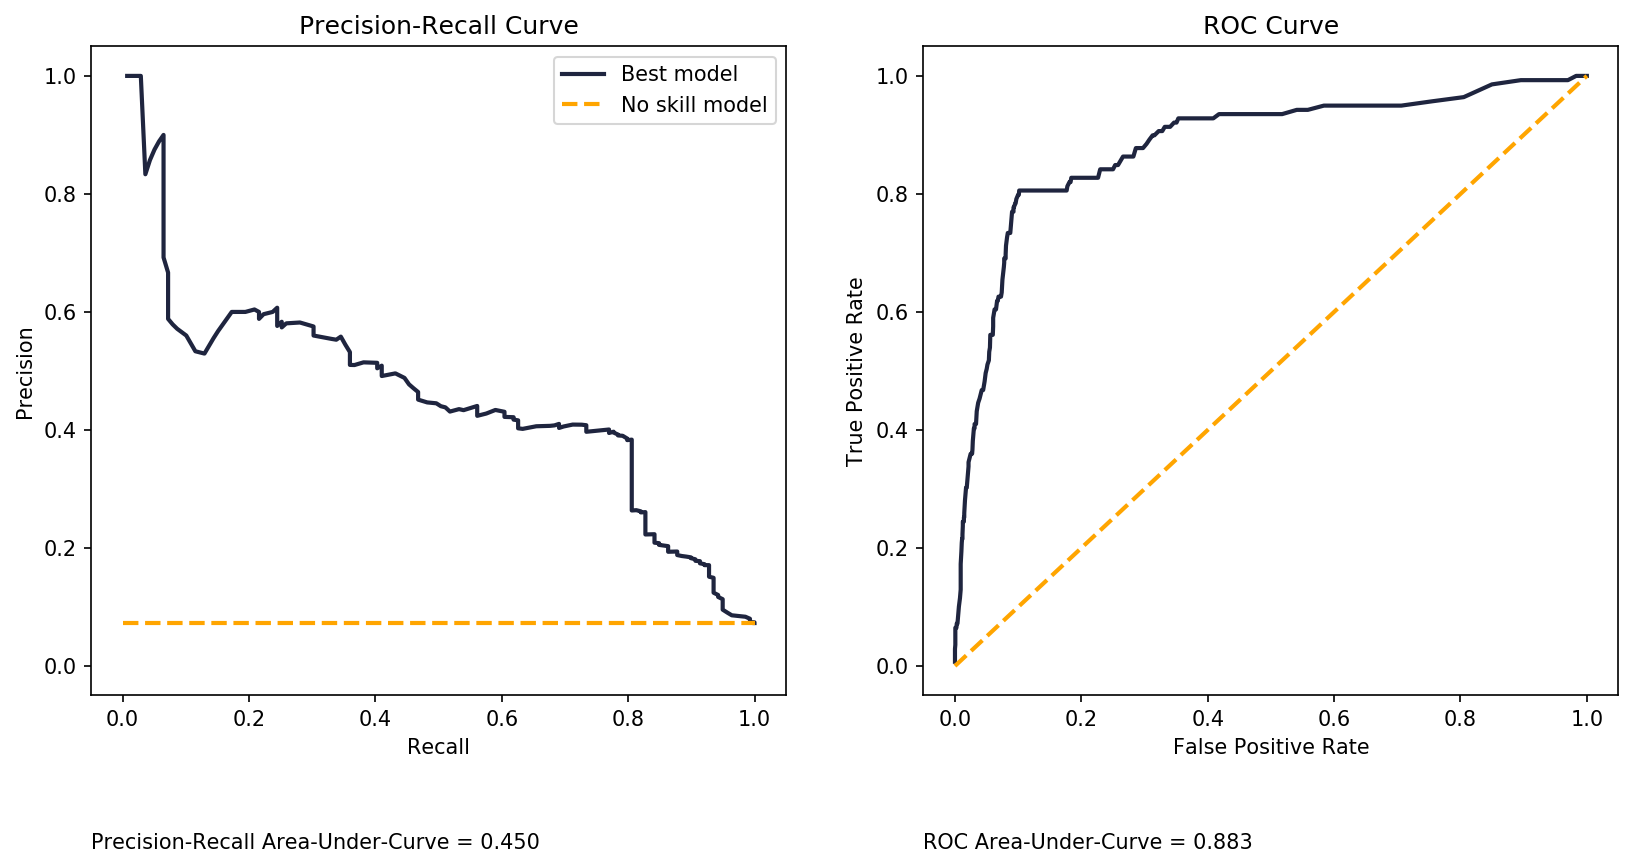

In [14]:
roc_auc_val = auc(fprs[0, :], tprs[0, :])
pr_auc_val = auc(recalls[0, :], precisions[0, :])

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

axes[0].plot(
    recalls[0, :],
    precisions[0, :],
    marker="",
    label="Best model",
    color=pal[5],
    linewidth=2,
)

axes[0].plot(
    np.array([0, 1]),
    np.array([0.073, 0.073]),
    marker="",
    linestyle="--",
    label="No skill model",
    color="orange",
    linewidth=2,
)

axes[0].legend()
axes[0].title.set_text("Precision-Recall Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].text(
    x=-0.05,
    y=-0.3,
    s="Precision-Recall Area-Under-Curve = {:.3f}".format(pr_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

axes[1].plot(
    fprs[0, :], tprs[0, :], marker="", label="Best model", color=pal[5], linewidth=2,
)

axes[1].plot(
    np.array([0, 1]),
    np.array([0, 1]),
    marker="",
    linestyle="--",
    label="No skill",
    color="orange",
    linewidth=2,
)

axes[1].title.set_text("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].text(
    x=-0.05,
    y=-0.3,
    s="ROC Area-Under-Curve = {:.3f}".format(roc_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelleft=True, which="major")
    ax.grid(False)
    

# plt.savefig('prauc_results.svg',dpi=150, bbox_inches = "tight")

plt.show()

The dashed lines in the above plot represent what a "no skilled model" would obtain if it was doing the anomaly detection -- that is, if a model randomly assigned a class (normal or abnorml) to each sub-cut in the data set. This random model is represented by a diagonal line in the ROC plot, and a horizontal line, set at a precision 0.073 (the percentage of failed sub-cuts in the testint set), on the PR-AUC plot. 

Compare the precision-recall curve and the ROC curve. The ROC curve gives a more optimistic view of the peformance of the model; that is an area-under-curve of 0.883. However, the precision-recall area-under-curve is not nearly as good, with a value of 0.450. Why the difference? It's because of the severe imbalance in our data set. This is the exact reason why you would want to use the PR-AUC instead of ROC-AUC metric. The PR-AUC will provide a more realistic view on the model's peformance.




## Violin Plot for the Latent Space
A violin plot is an effective method of visualizing the decision boundary and seeing where samples are misclassified. 

Here's the `violin_plot` function that will will use to create the plot. It takes the trained encoder, the sub-cuts (`X`), the labels (`y`), and an example threshold.

In [15]:
def violin_plot(
    model,
    X,
    y,
    example_threshold=0.034,
    caption="Distribution of Latent Space Anomaly Predictions",
    save_fig=False
):

    # generate the KL-divergence scores
    scores = build_kls_scores(model, X)

    colors = ["#e31a1c", "black"]

    # set your custom color palette
    customPalette = sns.set_palette(sns.color_palette(colors))

    min_x = scores.min()
    max_x = scores.max() + scores.max() * 0.05

    min_y = -0.5
    max_y = 2.7

    fig, ax = plt.subplots(1, 1, figsize=(8, 10),)

    # violin plot
    ax = sns.violinplot(
        x=scores,
        y=y,
        scale="count",
        inner=None,
        linewidth=2,
        color="white",
        saturation=1,
        cut=0,
        orient="h",
        zorder=0,
        width=1,
    )

    sns.despine(left=True)

    # strip plot
    ax = sns.stripplot(
        x=scores,
        y=y,
        size=6,
        jitter=0.15,
        color="black",
        linewidth=0.5,
        marker="o",
        edgecolor=None,
        alpha=0.1,
        palette=customPalette,
        zorder=4,
        orient="h",
    )

    # vertical line
    ax.plot(
        [example_threshold, example_threshold],
        [min_y, max_y],
        linestyle="--",
        label="",
        color="#d62728",
    )

    # add the fill areas for the predicted Failed and Healthy regions
    plt.fill_between(
        x=[0, example_threshold],
        y1=min_y,
        y2=max_y,
        color="#b2df8a",
        alpha=0.4,
        linewidth=0,
        zorder=0,
    )

    plt.fill_between(
        x=[example_threshold, max_x + 0.001],
        y1=min_y,
        y2=max_y,
        color="#e31a1c",
        alpha=0.1,
        linewidth=0,
        zorder=0,
    )

    # add text for the predicted Failed and Healthy regions
    ax.text(
        x=0 + (example_threshold) / 2,
        y=max_y - 0.2,
        s="Normal\nPrediction",
        horizontalalignment="center",
        verticalalignment="center",
        size=14,
        color="#33a02c",
        rotation="horizontal",
        weight="normal",
    )

    ax.text(
        x=example_threshold + (max_x - example_threshold) / 2,
        y=max_y - 0.2,
        s="Abnormal (failed)\nPrediction",
        horizontalalignment="center",
        verticalalignment="center",
        size=14,
        color="#d62728",
        rotation="horizontal",
        weight="normal",
    )

    # Set text labels and properties.
    plt.yticks([0, 1, 2], ["Healthy", "Degraded", "Failed"], weight="normal", size=14)
    plt.xlabel("")  # remove x-label
    plt.ylabel("")  # remove y-label

    plt.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,
        left=False,
    )

    ax.axes.get_xaxis().set_visible(False)  # hide x-axis
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.title(caption, x=0.05, y=0.97, loc="left", weight="normal", size=14)
    if save_fig:
        plt.savefig('violin_plot.png',dpi=150, bbox_inches = "tight")
    plt.show()

We need to load the encoder.

In [17]:
# load best encoder for latent space anomaly detection
folder_name_encoder = '20200620-053315_encoder'

loaded_json = open(r'models/best_models/{}/model.json'.format(folder_name_encoder), 'r').read()
encoder = model_from_json(loaded_json, custom_objects={'TCN': TCN, 'Sampling': Sampling})

# restore weights
encoder.load_weights(r'models/best_models/{}/weights.h5'.format(folder_name_encoder))

... and plot!

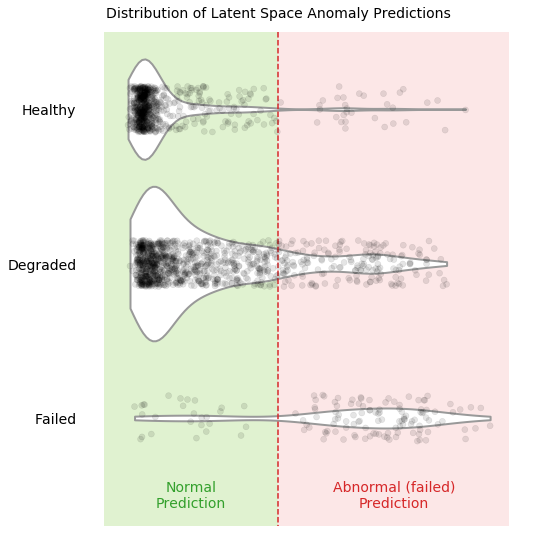

In [18]:
violin_plot(
    encoder,
    X_test,
    y_test,
    example_threshold=example_threshold_kl_test,
    caption="Distribution of Latent Space Anomaly Predictions",
    save_fig=False    
)

You can see in the above violin plot how different thresholds would misclassify varying numbers of data points (imagine the red dashed line moving left or right on the plot). This is the inherent struggle with anomaly detection -- seperating the noise from the anomalies.

## Compare Results for Different Cutting Parameters
If you remember from the previous posts, there are six cutting parameters in total:

* the metal type (either cast iron or steel)
* the depth of cut (either 0.75 mm or 1.5 mm)
* the feed rate (either 0.25 mm/rev or 0.5 mm/rev)

We can see if our selected anomaly detection model is better at detecting failed tools on one set of parameters over another. We'll do this by feeding only one type of parameter into the model at a time. For example, we'll feed the cuts that were made with cast-iron and see the results. Then we'll move to steel. Etc. etc.

### Code to Compare Parameters
There is a whole bunch of code needed to compare the different cutting parameters... feel free to skip to the bottom to see the results.

First, there are a number of functions needed to "filter" out the parameters we are not interested in. The input to these functions are the `X` data, a dataframe that has additional label data, `dfy`, and the parameter we are concerned with.

(side note: we'll have to generate the `dfy` later. In the original experiment, I did not think I would need the additional label information, like case, cut number, and cutting parameters. So I had to tack it on at the end)

In [19]:
def filter_x_material(X, dfy, material="cast_iron"):

    cast_iron_cases = [1, 2, 3, 4, 9, 10, 11, 12]
    steel_cases = list(list(set(range(1, 17)) - set(cast_iron_cases)))

    if material == "cast_iron":
        case_list = cast_iron_cases
    else:
        # material is 'steel'
        case_list = steel_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def filter_x_feed(X, dfy, feed):
    fast_feed_cases = [1, 2, 5, 8, 9, 12, 14, 16]
    slow_feed_cases = list(list(set(range(1, 17)) - set(fast_feed_cases)))

    if feed == 0.5:
        case_list = fast_feed_cases
    else:
        # feed is 0.25
        case_list = slow_feed_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def filter_x_depth(X, dfy, feed):
    deep_cases = [1, 4, 5, 6, 9, 10, 15, 16]
    shallow_cases = list(list(set(range(1, 17)) - set(deep_cases)))

    if feed == 1.5:
        case_list = deep_cases
    else:
        # depth is 0.75
        case_list = shallow_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted

Now we'll generate the `dfy` dataframes that include additional label information. These dataframes include the class, case, and the sequential count of each sub-cut.

To generate the `dfy`s we recreate the data prep pipeline.

In [20]:
# raw data location
data_file = folder_raw_data / "mill.mat"

prep = data_prep.DataPrep(data_file)

# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv(
    folder_processed_data / 'labels_with_tool_class.csv'
)


# discard certain cuts as they are strange
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace=True)

# return the X and y data, along with additional dfy datafram
X, y, dfy = prep.return_xy(df_labels, prep.data,prep.field_names[7:],window_size=64, stride=64, track_y=True)

# execute same splits -- IMPORTANT that the same random_state be used
X_train, X_test, dfy_train, dfy_test = train_test_split(X, dfy, test_size=0.33, random_state=15, 
                                                    stratify=dfy['class'])
X_val, X_test, dfy_val, dfy_test = train_test_split(X_test, dfy_test, test_size=0.50, random_state=10, 
                                                stratify=dfy_test['class'])

# we need the entire "X" data later
# so we need to make sure it is scaled appropriately
min_vals, max_vals = get_min_max(X_train)
X = scaler(X, min_vals, max_vals)


# reload the scaled data since we overwrote some of it above with
# unscaled data
# reload the data sets
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) 

This is what the `dfy_val` looks like:

In [21]:
dfy_val.head()

,class,counter,case
3804,0.0,54.0062,9.0
3643,0.0,52.0045,9.0
1351,0.0,20.0021,2.0
1167,1.0,16.0047,1.0
7552,0.0,109.0046,5.0


We can combine all the "filter" functions to see how the model peforms when only looking at one parameter at a time. This will take a bit more time to run since we have to iterate through the six different parameters.

In [22]:
model_folder = './models/best_models'
model_name = '20200620-053315_bvae'

grid_iterations = 250
search_iterations = 1 # <---- CHANGE THIS TO 4 TO GET SAME RESULTS AS IN PAPER (but takes loooong to run)

# look at different material types
# STEEL
X_train_mat1, y_train_mat1 =  filter_x_material(X, dfy_train, 'steel')
X_val_mat1, y_val_mat1 =  filter_x_material(X, dfy_val, 'steel')
X_test_mat1, y_test_mat1 =  filter_x_material(X, dfy_test, 'steel')

dfr_steel, _, _, _, _, _, _ = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_mat1, y_train_mat1, X_val_mat1, y_val_mat1, X_test_mat1, y_test_mat1)

# CAST-IRON
X_train_mat2, y_train_mat2 =  filter_x_material(X, dfy_train, 'cast_iron')
X_val_mat2, y_val_mat2 =  filter_x_material(X, dfy_val, 'cast_iron')
X_test_mat2, y_test_mat2 =  filter_x_material(X, dfy_test, 'cast_iron')

dfr_iron, _, _, _, _, _, _  = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_mat2, y_train_mat2, X_val_mat2, y_val_mat2, X_test_mat2, y_test_mat2)

# look at different feed rates
# 0.5 mm/rev
X_train_f1, y_train_f1 =  filter_x_feed(X, dfy_train, 0.5)
X_val_f1, y_val_f1 =  filter_x_feed(X, dfy_val, 0.5)
X_test_f1, y_test_f1 =  filter_x_feed(X, dfy_test, 0.5)

dfr_fast, _, _, _, _, _, _  = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_f1, y_train_f1, X_val_f1, y_val_f1, X_test_f1, y_test_f1)

# 0.25 mm/rev
X_train_f2, y_train_f2 =  filter_x_feed(X, dfy_train, 0.25)
X_val_f2, y_val_f2 =  filter_x_feed(X, dfy_val, 0.25)
X_test_f2, y_test_f2 =  filter_x_feed(X, dfy_test, 0.25)

dfr_slow, _, _, _, _, _, _  = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_f2, y_train_f2, X_val_f2, y_val_f2, X_test_f2, y_test_f2)

# look at different depths of cut
# 1.5 mm
X_train_d1, y_train_d1 =  filter_x_depth(X, dfy_train, 1.5)
X_val_d1, y_val_d1 =  filter_x_depth(X, dfy_val, 1.5)
X_test_d1, y_test_d1 =  filter_x_depth(X, dfy_test, 1.5)

dfr_deep, _, _, _, _, _, _  = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_d1, y_train_d1, X_val_d1, y_val_d1, X_test_d1, y_test_d1)

# 0.75 mm
X_train_d2, y_train_d2 =  filter_x_depth(X, dfy_train, 0.75)
X_val_d2, y_val_d2 =  filter_x_depth(X, dfy_val, 0.75)
X_test_d2, y_test_d2 =  filter_x_depth(X, dfy_test, 0.75)

dfr_shallow, _, _, _, _, _, _  = get_results(model_name, model_folder, grid_iterations, search_iterations, 
                X_train_d2, y_train_d2, X_val_d2, y_val_d2, X_test_d2, y_test_d2)

clear_output(wait=False)

We can now see the results for each of the six parameters.

In [23]:
# steel material
dfr_steel

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.430570,0.477521
1,validation,0.519147,0.579512
2,test,0.524665,0.522996


In [24]:
# cast-iron material
dfr_iron

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.044626,0.041689
1,validation,0.038812,0.037067
2,test,0.026930,0.029680


In [25]:
# fast feed rate, 0.5 mm/rev
dfr_fast

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.135335,0.144827
1,validation,0.272640,0.231796
2,test,0.232898,0.209018


In [26]:
# slow feed rate, 0.25 mm/rev
dfr_slow

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.582924,0.599790
1,validation,0.606066,0.672304
2,test,0.590973,0.645599


In [27]:
# deep cuts, 1.5 mm in depth
dfr_deep

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.122281,0.118633
1,validation,0.118372,0.124065
2,test,0.162790,0.158938


In [28]:
# shallow cuts, 0.75 mm in depth
dfr_shallow

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.721970,0.749864
1,validation,0.827365,0.829849
2,test,0.736809,0.804361


### Make the Plot and Discuss
Let's combine all the results into one table and plot the results on a bar chart.

In [29]:
# parameter names
cutting_parameters = [
    "Steel",
    "Iron",
    "0.25 Feed\nRate",
    "0.5 Feed\nRate",
    "1.5 Depth",
    "0.75 Depth",
]

# pr-auc latent scores
pr_auc_latent = [
    dfr_steel[dfr_steel['Data Set']=='test']['PR-AUC Latent Space'].iloc[0],
    dfr_iron[dfr_iron['Data Set']=='test']['PR-AUC Latent Space'].iloc[0],
    dfr_slow[dfr_slow['Data Set']=='test']['PR-AUC Latent Space'].iloc[0],
    dfr_fast[dfr_fast['Data Set']=='test']['PR-AUC Latent Space'].iloc[0],
    dfr_deep[dfr_deep['Data Set']=='test']['PR-AUC Latent Space'].iloc[0],
    dfr_shallow[dfr_shallow['Data Set']=='test']['PR-AUC Latent Space'].iloc[0],
]

# make the dataframe and sort values from largest to smallest
dfr_param = (
    pd.DataFrame(
        {"Parameter": cutting_parameters, "PR-AUC Latent Score": pr_auc_latent}
    )
    .round(3)
    .sort_values("PR-AUC Latent Score", ascending=False)
)

dfr_param

,Parameter,PR-AUC Latent Score
5,0.75 Depth,0.804
2,0.25 Feed\nRate,0.646
0,Steel,0.523
3,0.5 Feed\nRate,0.209
4,1.5 Depth,0.159
1,Iron,0.030


... and make a pretty plot!

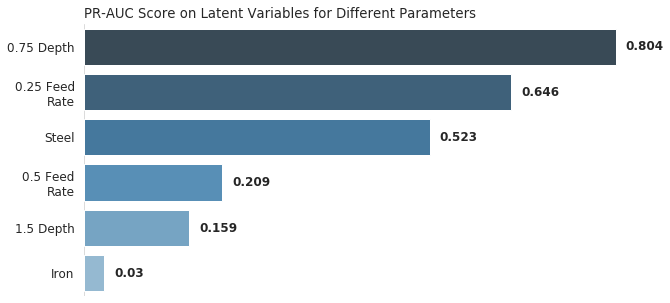

In [30]:
sns.set(font_scale=1.1, style="whitegrid") # set format

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),)

ax = sns.barplot(
    "PR-AUC Latent Score", y="Parameter", data=dfr_param, palette="Blues_d",
)

for p in ax.patches:
    # help from https://stackoverflow.com/a/56780852/9214620
    space = 0.015
    _x = p.get_x() + p.get_width() + float(space)
    _y = p.get_y() + p.get_height() / 2
    value = p.get_width()
    ax.text(_x, _y, value, ha="left", va="center", weight="semibold", size=12)

ax.spines["bottom"].set_visible(True)
ax.set_ylabel("")
ax.set_xlabel("")
ax.grid(alpha=0.7, linewidth=1, axis="x")
ax.set_xticks([0])
ax.set_xticklabels([])
plt.title("PR-AUC Score on Latent Variables for Different Parameters", loc="left")

sns.despine(left=True, bottom=True)
plt.savefig('prauc_params.svg',dpi=150,bbox_inches = "tight")
plt.show()

Clearly, this "best" model finds some cutting parameters more useful than others. Certain cutting parameters may produce signals carrying more information and/or have a higher signal-to-noise ratio.

The model may also develop a preference, during training, for some parameters over others. The preference may be a function of the way the model was constructed (e.g. the $\beta$ parameter or the coding size), along with the way the model was trained. I suspect that there may be other model configurations that prefer other parameters, such as cast-iron over steel. An [ensemble of models](https://en.wikipedia.org/wiki/Ensemble_learning) may thus produce significantly better results. This would be an interesting area of further research!

## Trend the KL-Divergence Scores
The KL-divergence scores can be trended sequentially to see how our anomaly detection model works. This is my favourite chart -- it's pretty, and gives good insight. Note: you can also trend the input space reconstruction errors, but we won't do that here (check out the [other github repository](https://github.com/tvhahn/ml-tool-wear) to see it being done).

First, let's do some quick exploration to see how these trends will look. 

We need a function to sort the sub-cuts sequentially:

In [31]:
def sorted_x(X, dfy, case):
    """Function that sorts the sub-cuts based on case no. and a dfy dataframe"""
    
    index_keep = dfy[dfy["case"] == case].sort_values(by=["counter"].copy()).index
    X_sorted = X[index_keep]
    y_sorted = np.array(
        dfy[dfy["case"] == case].sort_values(by=["counter"])["class"].copy()
    )
    return X_sorted, y_sorted

Now do a quick plot of the trend.

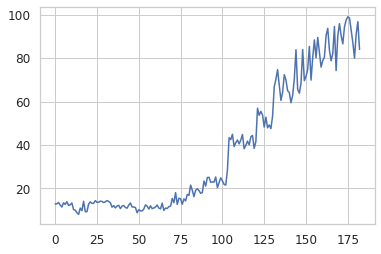

In [32]:
# try the same, as above, but in the latent space
X_sort, y_sort = sorted_x(X, dfy_val, 13)

kls = build_kls_scores(encoder, X_sort)
plt.plot(kls)

We now have all we need to create a plot that trends the KL-divergence score over time.

In [33]:
def plot_one_signal_sequentially(
    scores,
    y_sort,
    case_no,
    avg_window_size=10,
    dpi=150,
    opacity_color=0.10,
    opacity_grid=0.10,
    caption="Latent Space KL-Divergence Trend",
    y_label="KL-Divergence Score",
    legend_label="KL-Divergence",
    save_fig=False
):
    """
    Make a trend of the reconstruction or KL-divergence score.
    """

    # plot parameters
    colors = ["#33a02c", "#fdbf6f", "#e31a1c"]  # green, orange, red
    failed_reg = ["Healthy", "Degraded", "Failed"]
    pad_size = 0
    x_min = -pad_size

    # create pallette for color of trend lines
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

    # get the parameters based on the case number
    # and append to the caption
    if case_no in [1, 2, 3, 4, 9, 10, 11, 12]:
        material = 'cast iron'
    else:
        material = 'steel'
    if case_no in [1, 2, 5, 8, 9, 12, 14, 16]:
        feed_rate = 'fast speed'
    else:
        feed_rate = 'slow speed'
    if case_no in [1, 4, 5, 6, 9, 10, 15, 16]:
        cut_depth = 'deep cut'
    else:
        cut_depth = 'shallow cut'
    
    # set the title of the plot
    caption = f'{caption} for Case {case_no} ({material}, {feed_rate}, {cut_depth})'
    
    # identify where the tool class changes (from healthy, to degraded, to failed)
    tool_class_change_index = np.where(y_sort[:-1] != y_sort[1:])[0] - avg_window_size

    # need the index to start at zero. Concatenate on a zero
    tool_class_change_index = np.concatenate(
        ([0], tool_class_change_index, [np.shape(y_sort)[0] - avg_window_size + 1])
    )

    indexer = (
        np.arange(2)[None, :]
        + np.arange(np.shape(tool_class_change_index)[0] - 1)[:, None]
    )

    # establish shaded region
    shade_reg = tool_class_change_index[indexer]

    x_max = len(y_sort) - avg_window_size + pad_size

    # define colour palette and seaborn style for plot
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        1, 1, dpi=150, figsize=(7, 2.5), sharex=True, constrained_layout=True,
    )

    # moving average function
    def moving_average(a, n=3):
        # from https://stackoverflow.com/a/14314054
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1 :] / n
    
    x = moving_average(scores, n=1)
    x2 = moving_average(scores, n=avg_window_size)
    y_avg = np.array([i for i in range(len(x2))]) + avg_window_size
    axes.plot(y_avg, x2, linewidth=1.5, alpha=1, color=pal[5], label="Rolling average")
    axes.plot(x, linewidth=0.5, alpha=0.5, color="grey", label=legend_label)
    y_min = np.min(x)
    y_max = np.max(x)
    y_pad = (np.abs(y_min) + np.abs(y_max)) * 0.02

    # remove all spines except bottom
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.spines["left"].set_visible(False)  
    axes.spines["bottom"].set_visible(True)
    
    # set bottom spine width
    axes.spines["bottom"].set_linewidth(0.5)
    
    # very light gridlines
    axes.grid(alpha=opacity_grid, linewidth=0.5)
    
    # set label size for ticks
    axes.tick_params(axis="x", labelsize=7.5)
    axes.tick_params(axis="y", labelsize=7.5)


    # colors
    axes.set_ylim(y_min - y_pad, y_max + y_pad)
    axes.set_xlim(x_min, x_max)

    for region in range(len(shade_reg)):

        f = failed_reg[region % 3]
        c = colors[region % 3]
        axes.fill_between(
            x=shade_reg[region],
            y1=y_min - y_pad,
            y2=y_max + y_pad,
            color=c,
            alpha=opacity_color,
            linewidth=0,
            zorder=1,
        )

        # for text
        axes.text(
            x=(
                shade_reg[region][0] + (shade_reg[region][1] - shade_reg[region][0]) / 2
            ),
            y=y_max + y_pad - y_max * 0.1,
            s=f,
            horizontalalignment="center",
            verticalalignment="center",
            size=8.5,
            color=c,
            rotation="horizontal",
            weight="semibold",
            alpha=1,
        )

    # axis label
    axes.set_xlabel("Sample Number", fontsize=7.5)
    axes.set_ylabel(y_label, fontsize=7.5)

    fig.suptitle(caption, fontsize=8.5)
#     plt.legend(
#         loc="center left", bbox_to_anchor=(0.02, 0.6), fontsize=7.5,
#     )
    
    if save_fig:
        plt.savefig(f'{caption}.png',dpi=250, bbox_inches="tight")
    plt.show()


We'll trend case 13, which is peformed on steel, at slow speed, and is a shallow cut.

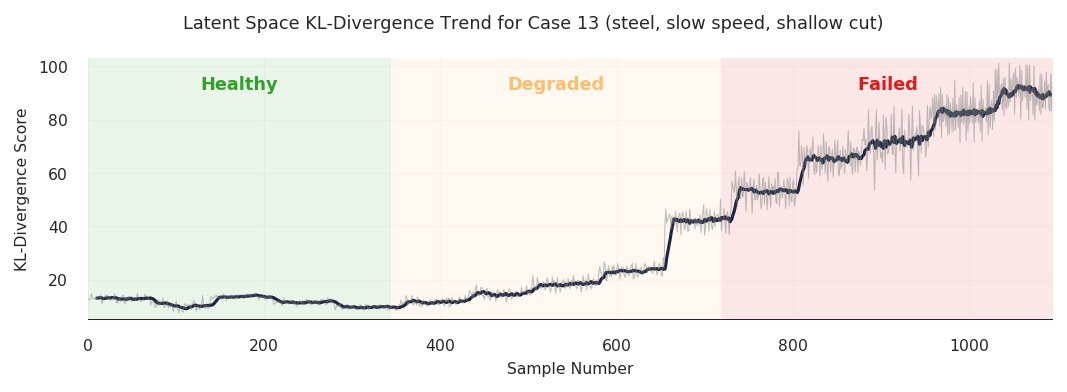

In [34]:
case = 13

X_sort, y_sort = sorted_x(X, dfy, case)
kls = build_kls_scores(encoder, X_sort)

plot_one_signal_sequentially(kls, y_sort, case, save_fig=False)

Looks pretty good! The model produces a nice clear trend. However, as we've seen in the previous section, our anomaly detection model does have some difficulty in discerning when a tool is abnormal (failed or unhealthy) under certain cutting condititions. Let's look at another example -- case 11.

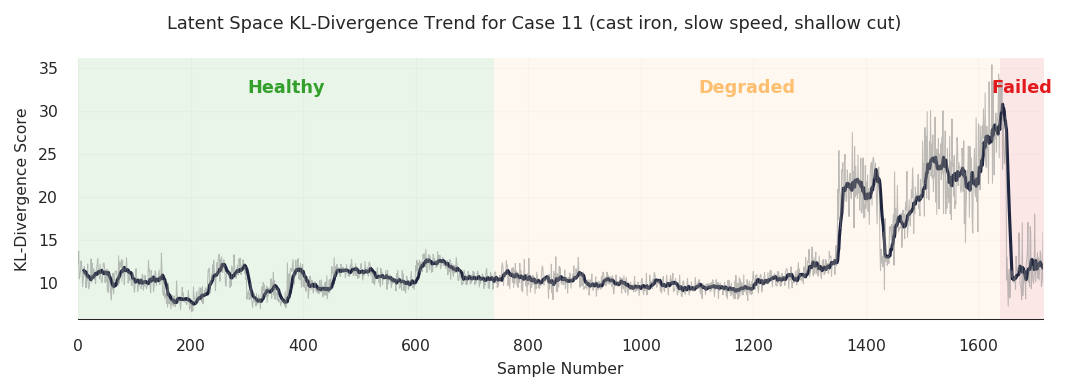

In [35]:
case = 11

X_sort, y_sort = sorted_x(X, dfy, case)
kls = build_kls_scores(encoder, X_sort)

plot_one_signal_sequentially(kls, y_sort, case, save_fig=False)

You can see how the trend increases through the "degraded" area, but then promptly drops off when it reaches the red "failed" area. Why? Well, I don't know exactly. It could be that the samples at the end of the trend are more similar to healthy samples. There is much more analysis that could be done... which I'll leave up to you. Change the case number and see what you get.

# Further Ideas
What we've gone through here is a method to do anomaly detection, on an industrial data set, using a VAE. I have no doubt that these methods can be improved upon, and that other interesting areas can be explored. I hope that some industrious researcher or student can use this as a spring-board to do some really interesting things! Here are some things I'd be interested in doing further:

* As I mentioned above, an ensemble of models may produce significantly better results.
* The $\beta$ in the VAE makes this a disentangled-variational-autoencoder. It would be interesting to see how the codings change with different cutting parameters, and if the codings do represent certain cutting parameters.
* I used the TCN in the VAE, but I think a regular convolutional neural network, with dilations, would work well too (that's my hunch). This would make the model training simpler.
* If I were to start over again, I would integrate in more model tests. These model tests (like unit tests) would check the model's peformance against the different cutting parameters. This would make it easier to find which models generalize well across a cutting parameters.

# Conclusion
In this post we've explored the peformance of our trained VAE model. We found that using the latent space for anomaly detection, using KL-divergence, was more effective than the input space anomaly detection. The principals demonstrated here can be used across many domains where anomaly detection is used.

I hope you've enjoyed this series, and perhaps, have learned something new. If you found this useful, and are an academic researcher, feel free to cite the work ([preprint of the IJHM paper here](https://www.researchgate.net/publication/350842309_Self-supervised_learning_for_tool_wear_monitoring_with_a_disentangled-variational-autoencoder)). And give me a follow on Twitter!

# References 

An, Jinwon, and Sungzoon Cho. "[Variational autoencoder based anomaly detection using reconstruction probability](http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf)." Special Lecture on IE 2.1 (2015): 1-18.

Davis, Jesse, and Mark Goadrich. "[The relationship between Precision-Recall and ROC curves](https://dl.acm.org/doi/pdf/10.1145/1143844.1143874?casa_token=CSQzAhypHQ0AAAAA:WqAGJXokpttfPIStrcXb_2tXdufgXdDu085FVIBhtQA1hLgXZrJGVHThaTBx4tzGUky8KTRuMJqidg)." Proceedings of the 23rd international conference on Machine learning. 2006.

Saito, Takaya, and Marc Rehmsmeier. "[The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)." PloS one 10.3 (2015): e0118432.